Rough outline

-import data
-apply train test split
-apply some models
-output preds

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [159]:
nvda_df = pd.read_csv("NVDA_YTD.csv", parse_dates = ["Date"], index_col = 'Date')

In [160]:
nvda_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-25,229.729996,233.550003,227.699997,231.660004,231.474442,23023500
2021-10-26,239.889999,252.589996,239.240005,247.169998,246.972015,48589800
2021-10-27,244.740005,250.899994,242.820007,244.509995,244.314148,24599000
2021-10-28,248.779999,249.500000,245.229996,249.410004,249.210236,23420400
2021-10-29,250.009995,257.089996,250.000000,255.669998,255.465210,29250300


In [161]:
nvda_df.shape

(251, 6)

In [162]:
df_close = nvda_df["Close"]

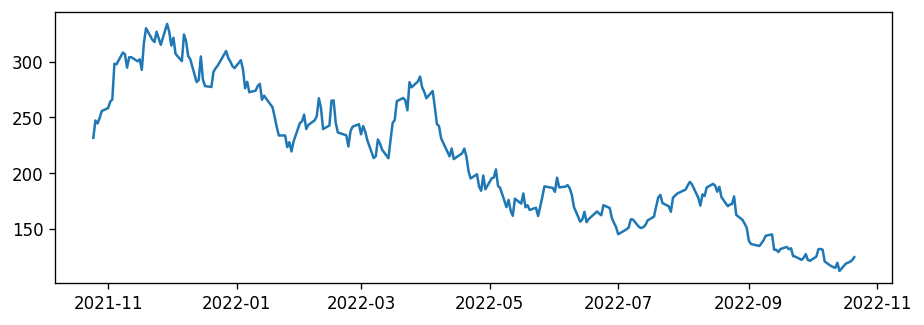

In [163]:
plt.plot(df_close)

In [164]:
def test_stationary(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

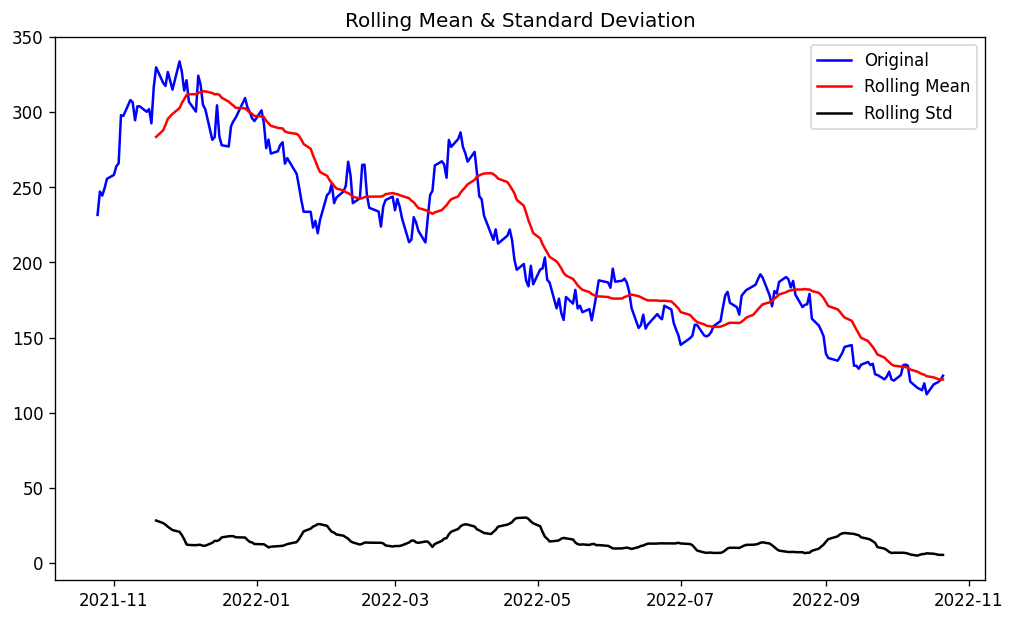

Results of Dickey-Fuller Test:
Test Statistic                  -0.714420
p-value                          0.842979
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [165]:
plt.figure(figsize = (10,6))
test_stationary(df_close)

<Figure size 1080x360 with 0 Axes>

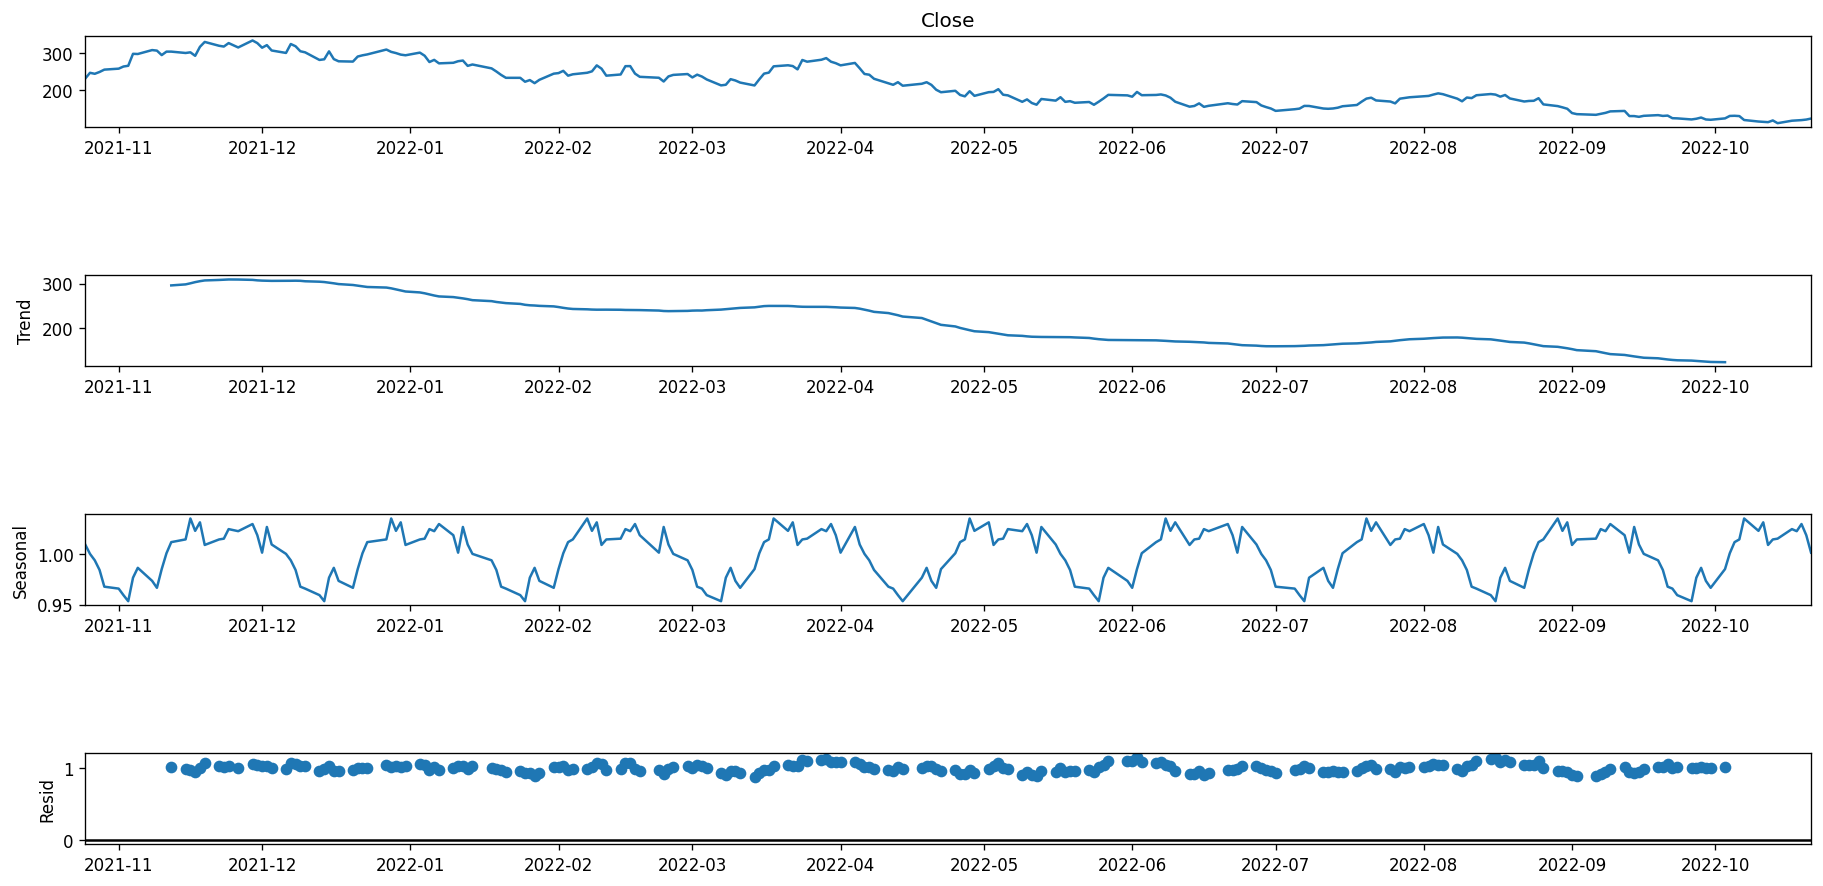

In [166]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a 
# month

result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

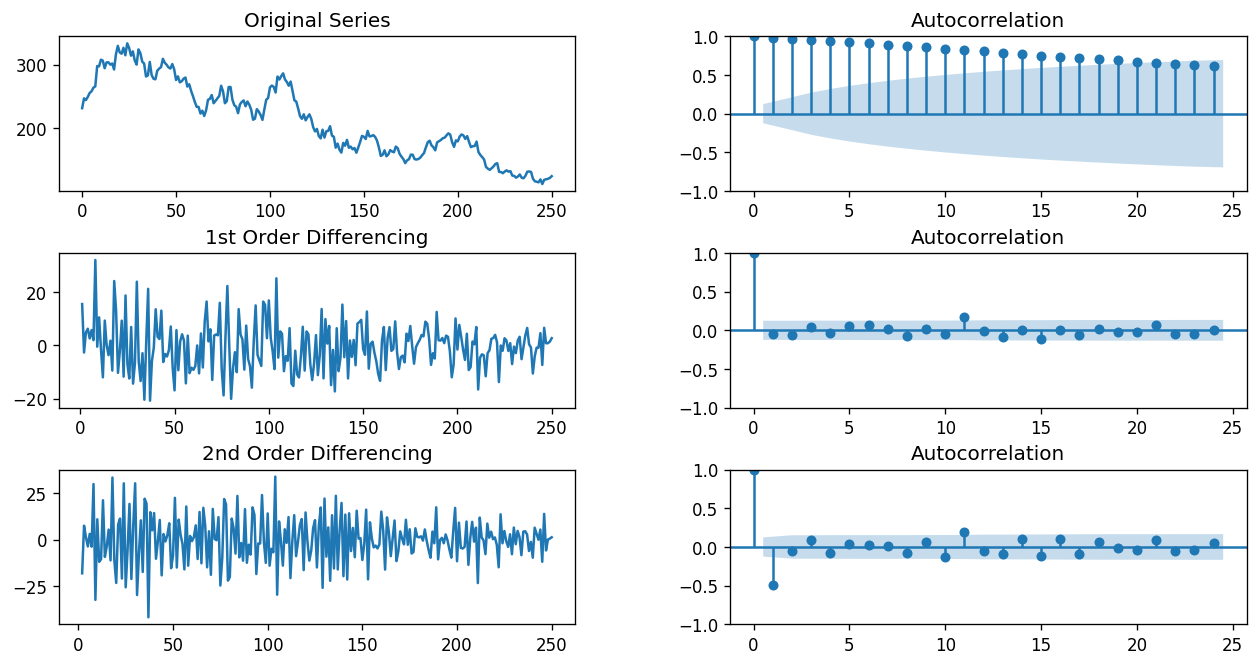

In [167]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})



# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_close.values)
axes[0, 0].set_title('Original Series')
plot_acf(df_close.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_close.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_close.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_close.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_close.diff().diff().dropna().values, ax=axes[2, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.4,
                    right=1.2,
                    top=1.1,
                    wspace=0.3,
                    hspace=0.4)

plt.show()

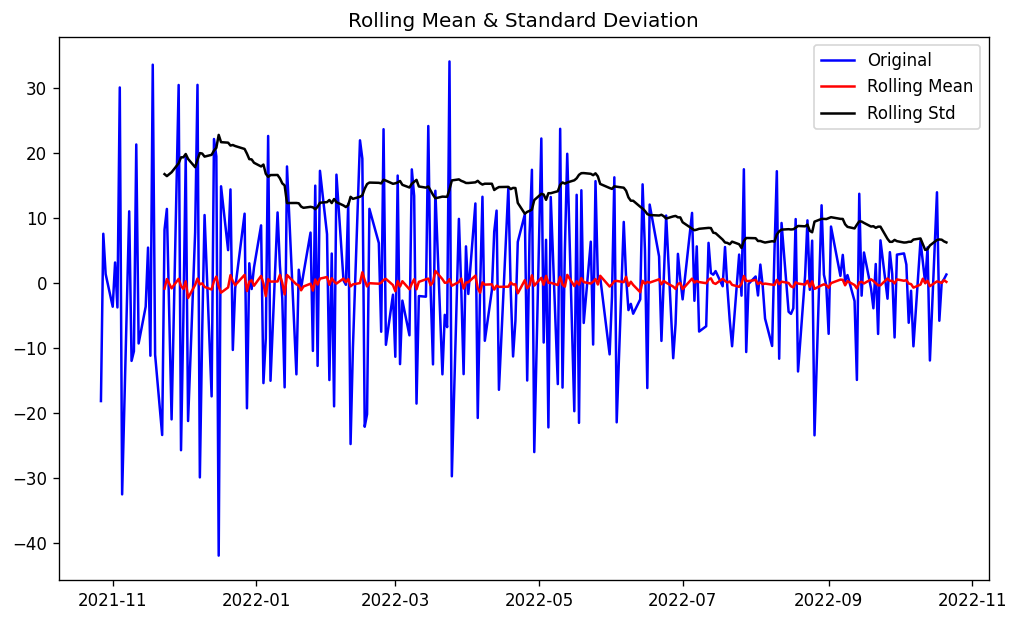

Results of Dickey-Fuller Test:
Test Statistic                -9.339929e+00
p-value                        8.853176e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


In [168]:
df_close_shift = df_close.diff().diff()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationary(df_close_shift)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

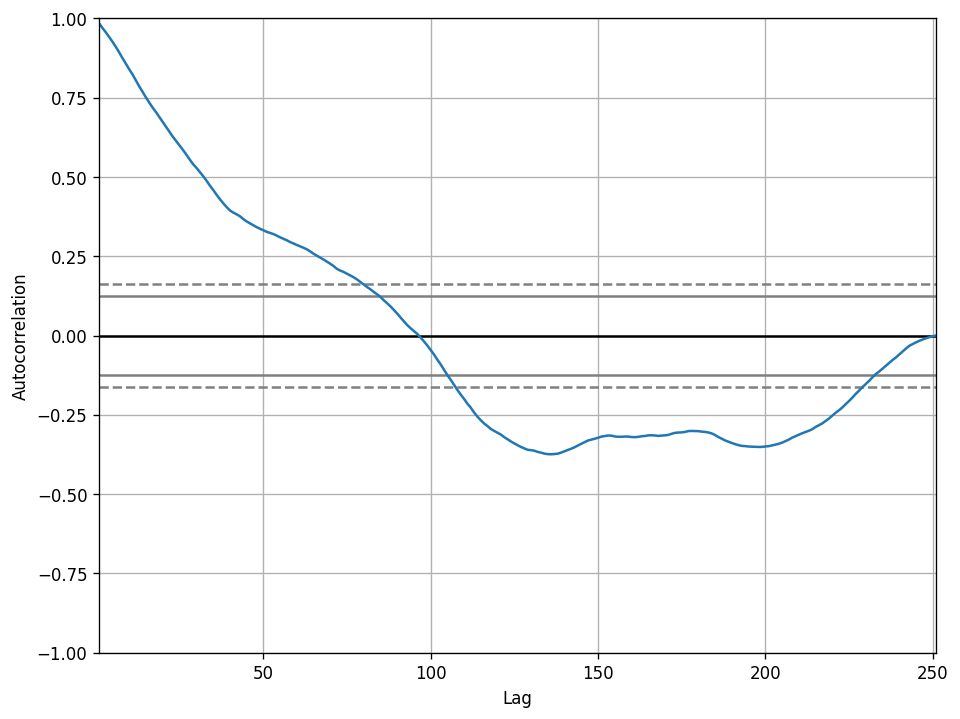

In [169]:
pd.plotting.autocorrelation_plot(df_close)

C:\Users\drust\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


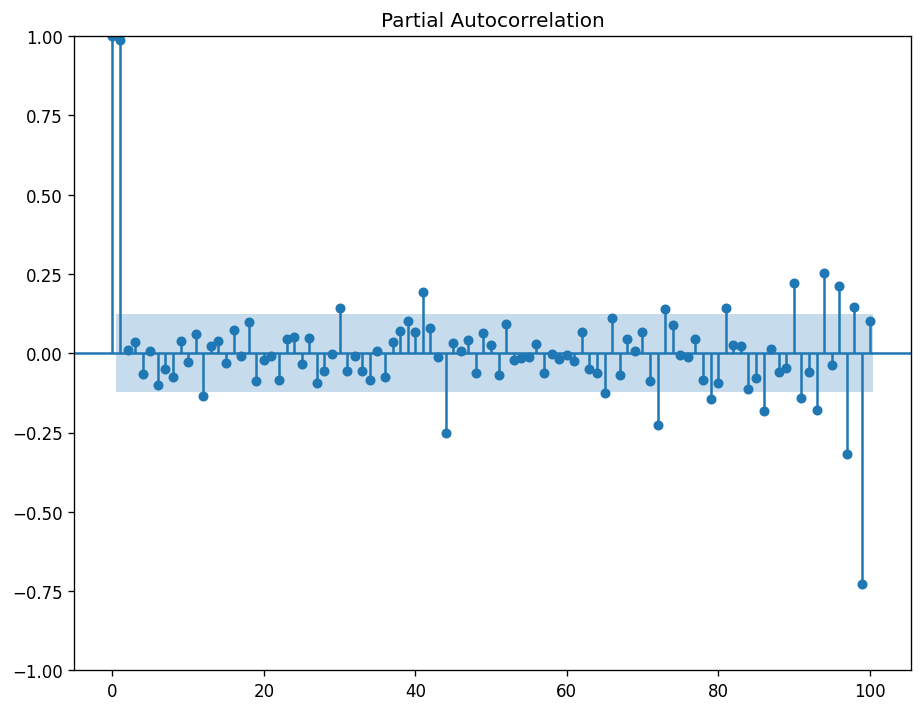

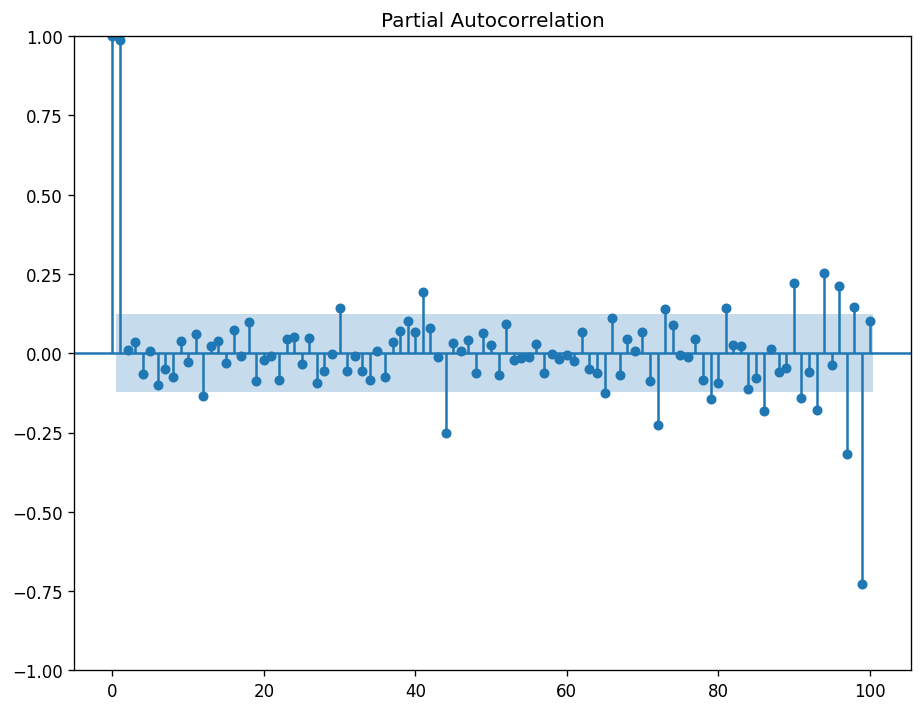

In [170]:
plot_pacf(df_close, lags = 100)

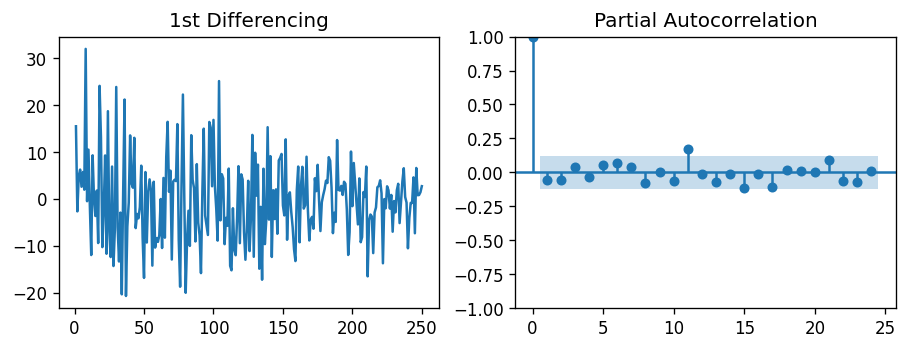

In [171]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_close.diff().values); axes[0].set_title('1st Differencing')
plot_pacf(df_close.diff().dropna().values, ax=axes[1])

plt.show()

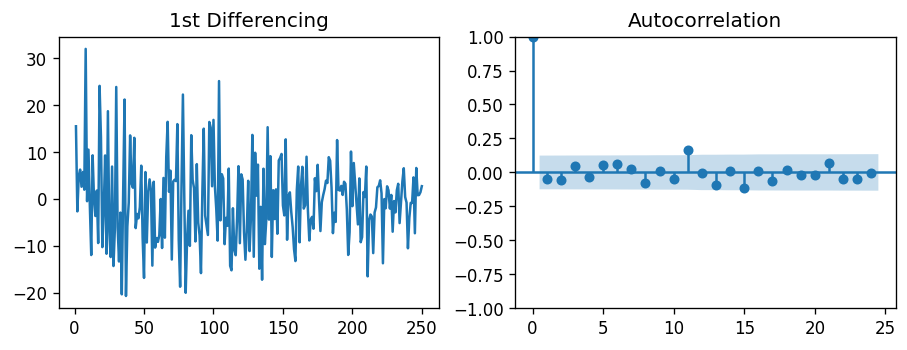

In [172]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_close.diff().values); axes[0].set_title('1st Differencing')
plot_acf(df_close.diff().dropna().values, ax=axes[1])

plt.show()

In [187]:
from statsmodels.tsa.arima.model import ARIMA

# 5,1,2 ARIMA Model
model = ARIMA(df_close.values, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -898.004
Date:                Sun, 23 Oct 2022   AIC                           1802.008
Time:                        23:31:05   BIC                           1812.561
Sample:                             0   HQIC                          1806.256
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0486      0.066     -0.738      0.461      -0.178       0.080
ma.L1         -0.9993      0.227     -4.400      0.000      -1.444      -0.554
sigma2        77.7127     18.295      4.248      0.0

In [188]:
predictions = model_fit.predict(start = 0, end = 13)
print(len(predictions))

14


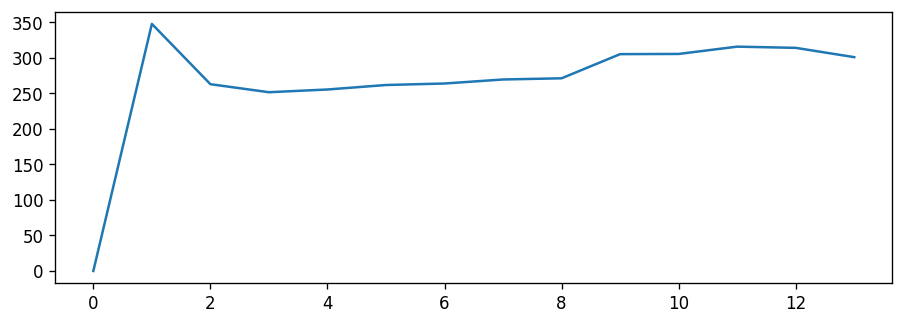

In [189]:
plt.plot(predictions)

In [194]:
predictions[2:12]

array([262.69722402, 251.38524116, 255.23865163, 261.5429722 ,
       263.65381512, 269.30160067, 270.97386464, 304.96274425,
       305.21685553])

In [195]:
preds = pd.DataFrame(predictions[2:12], columns = ["Close"])
preds.index.name = "Index"
preds

,Close
Index,
0,262.697224
1,251.385241
2,255.238652
3,261.542972
4,263.653815
5,269.301601
6,270.973865
7,304.962744
8,305.216856


In [196]:
preds.to_csv("YEO_JUN_TENG_DRUSTAN_Impl_2.csv")